<a href="https://colab.research.google.com/github/RoshanM-18/Intermediate-Deep-Learning-projects-using-Tensorflow-Keras/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
import os
import zipfile
import time
import random
import shutil

#### Downloading the data from kaggle

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

In [ ]:
!kaggle datasets download -d jeffheaton/glasses-or-no-glasses

100% 6.11G/6.11G [02:05<00:00, 45.0MB/s]



In [ ]:
zip_ref = zipfile.ZipFile("/content/glasses-or-no-glasses.zip")
zip_ref.extractall()
zip_ref.close()

#### Becoming one with the data

In [ ]:
data_dir = "/content/faces-spring-2020/faces-spring-2020"

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.head(10)

,id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,...,v474,v475,v476,v477,v478,v479,v480,v481,v482,v483,v484,v485,v486,v487,v488,v489,v490,v491,v492,v493,v494,v495,v496,v497,v498,v499,v500,v501,v502,v503,v504,v505,v506,v507,v508,v509,v510,v511,v512,glasses
0,1,0.37797,-0.94808,0.01346,0.17893,0.37795,0.63571,0.13943,-0.25607,-0.39341,1.08947,-1.36048,-1.31529,0.36119,-0.62857,-1.65290,1.47167,-0.88741,-0.25942,-0.34414,-0.38914,0.38425,-0.50553,-0.09451,0.30568,-1.07570,-0.65924,1.10918,1.22234,-0.12479,0.50198,-0.63932,0.61505,1.16747,0.36921,-0.44398,0.46192,-0.83207,-0.74952,-0.40722,...,0.54072,-0.71995,1.11262,-0.11429,0.85618,0.17233,-1.06815,0.04569,-0.13031,2.07549,0.47934,0.69172,1.37139,0.45480,-0.96053,0.06319,0.09664,-0.34749,0.09889,-0.87606,0.82594,0.52841,0.84209,0.16771,0.59003,-0.22960,-0.04017,0.15554,-0.41569,0.68050,-0.03494,1.32443,-0.94570,0.02055,-1.23908,0.43507,1.08635,1.69027,0.61609,0
1,2,0.07609,-0.09774,0.39666,-0.39026,0.10606,0.52774,0.07105,0.33720,0.69917,-0.02842,-0.56431,0.42060,-0.47533,1.60025,-0.02106,-2.30193,-0.31614,-0.08050,0.85041,-0.10574,-0.33177,-1.32102,-0.22244,-0.52076,0.40012,-0.41339,-0.15176,1.02155,-0.52834,0.66718,0.54844,0.18323,0.28764,-0.80084,-0.85040,0.45097,0.88317,-1.13375,-1.85301,...,-0.25966,-1.19259,-0.71514,-0.08903,-0.58853,-0.20697,-0.77025,-1.21129,-0.67575,0.32509,-0.35147,-0.33581,-0.31505,-1.66721,0.40666,0.15053,-0.77809,0.35837,-1.10950,0.03764,-0.93728,-0.68952,-0.92334,-0.35401,-1.20552,1.10199,0.46268,0.85954,-0.48484,-0.54585,0.86624,-1.24953,-0.21511,-1.54146,1.04765,-1.24035,0.00866,-1.27640,-0.60496,1
2,3,1.19391,-0.68707,-0.68422,-0.36378,-0.60847,-0.40118,1.45432,0.00592,1.68940,-0.98205,0.67435,-1.27604,-1.37050,-0.91682,0.23617,0.53676,-0.26815,-0.66989,0.46076,-0.04117,1.34078,0.46545,-0.25943,-0.22918,-0.49346,-0.53558,0.69776,1.15477,0.01293,-0.86763,-0.08987,0.54660,0.09142,-0.21663,-0.28233,0.15426,-1.02164,-0.24342,-0.18844,...,0.91472,-0.29778,0.45507,0.03296,-0.79752,1.19759,-0.45417,0.15993,0.39516,-0.87621,0.05737,-0.99432,1.19910,0.78989,-0.13908,0.12384,0.38121,0.05699,-0.89445,-0.67448,-0.07669,-1.50409,0.07962,0.95116,0.72782,-0.88516,0.40735,0.10415,0.31639,-0.34801,-0.35893,0.02330,0.31548,-0.34923,-0.41772,-0.58175,-0.60177,0.43555,0.41982,1
3,4,1.34949,-0.31498,-1.30248,0.50278,1.66292,-1.06094,-0.70835,-0.24237,-0.15509,-0.04532,0.97349,-0.21032,-0.71143,0.59725,-0.51849,0.00126,1.22219,0.57160,0.41212,0.90077,-0.80797,-1.20564,1.40774,0.49080,-1.05429,0.26300,-0.03849,-0.66792,-0.29260,0.47713,0.44967,0.44411,-0.13465,-0.20365,0.52841,-0.47348,0.39295,0.67695,0.40861,...,0.65551,-0.17916,0.55700,1.84589,0.70722,-0.55871,-1.18265,0.82509,-0.50715,0.71948,-1.08462,-0.05607,0.86918,-0.11338,-0.73700,-0.12130,0.81417,-0.61391,-0.90671,1.09301,0.37716,1.06373,-0.62199,-0.21279,-0.43245,-0.28904,-0.25435,-0.20458,-0.00398,1.18449,0.23942,0.20774,0.81792,-0.74814,-0.62521,0.01689,0.83997,-0.46986,0.06755,0
4,5,-0.03512,-0.34196,0.14230,1.50513,-0.14364,0.49429,0.07823,-0.04356,0.42009,-0.88828,0.13601,0.26917,0.11973,0.04378,1.06879,0.10060,-0.83331,-0.64776,0.26461,0.65249,-0.41807,0.65920,0.11838,-0.00525,-0.74657,-0.97743,-0.71398,-0.08356,-0.82942,0.60474,0.12790,-0.41187,-2.18319,0.27367,0.54507,0.26555,0.67382,-0.24832,0.43397,...,0.90449,-0.51652,-0.11353,1.59131,-0.15053,-0.03551,0.02906,0.16957,0.62629,0.71465,-0.77525,0.46366,0.03279,-0.17744,0.32256,0.16237,-0.52918,-1.07961,0.55594,0.07770,0.08003,0.86164,0.24552,-0.17842,0.57825,0.01275,-1.05442,-0.61130,0.72826,-1.61306,-1.78407,0.07465,1.50182,-0.41289,-0.55908,-0.29702,0.83641,0.59756,-0.20298,0
5,6,-0.46177,-0.29613,0.61101,-1.00880,0.29751,-1.08969,-0.85424,-0.13436,-1.53843,-0.75731,-0.34578,-0.61463,-0.45296,-0.94544,0.99837,0.52330,-0.96145,0.34110,0.01358,-0.50289,-0.08764,0.38965,-0.03499,-0.14619,-0.80936,-0.93604,1.04069,-0.46338,0.16818,0.99486,0.03724,-0.

In [ ]:
images_names = os.listdir(data_dir)

In [ ]:
glasses_train = [x for x in train[train["glasses"]==1]["id"].values.tolist()]
no_glasses_train = [x for x in train[train["glasses"]==0]["id"].values.tolist()]

In [ ]:
len(glasses_train), len(no_glasses_train)

(2856, 1644)

In [ ]:
train_glasses_images = []
train_non_glasses_images = []

for x in images_names:
  value = int(x.split("-")[1].split(".")[0])
  if value in glasses_train:
    train_glasses_images.append(x)
  elif value in no_glasses_train:
    train_non_glasses_images.append(x)
  else:
    continue

In [ ]:
len(train_glasses_images), len(train_non_glasses_images)

(2856, 1644)

Glasses


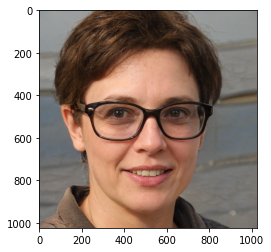

In [ ]:
random_img = np.random.choice(len(train_glasses_images))

img_path = data_dir + "/" + train_glasses_images[random_img]

img = mpimg.imread(img_path)
plt.imshow(img)
print("Glasses")
plt.show()

No Glasses


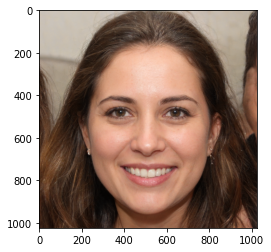

In [ ]:
random_img = np.random.choice(len(train_non_glasses_images))

img_path = data_dir + "/" + train_non_glasses_images[random_img]

img = mpimg.imread(img_path)
plt.imshow(img)
print("No Glasses")
plt.show()

In [ ]:
os.mkdir("train")

In [ ]:
%cd train
os.mkdir("glasses")
os.mkdir("no_glasses")
%cd ..

/content/train
/content


In [ ]:
for x in train_glasses_images:
  img = data_dir + "/" + x
  shutil.copy(img, "/content/train/glasses")

In [ ]:
for x in train_non_glasses_images:
  img = data_dir + "/" + x
  shutil.copy(img, "/content/train/no_glasses")

In [ ]:
for dirpath, dirnames, filenames in os.walk("/content/train"):
  print("There are {} directories and {} images in {}".format(len(dirnames), len(filenames), dirpath))

There are 2 directories and 0 images in /content/train
There are 0 directories and 1644 images in /content/train/no_glasses
There are 0 directories and 2856 images in /content/train/glasses


### Making tf dataset and creating batches 

In [ ]:
train_dir = "/content/train"

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
  train_dir, color_mode="rgb", image_size=(224, 224), batch_size=32, shuffle=True, label_mode="binary" 
)

Found 4500 files belonging to 2 classes.


In [ ]:
train_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>

### Creating the generator part of the GAN model

In [ ]:
def generator_model():

  model = keras.Sequential([
      keras.layers.Dense(7*7*256, use_bias=False, input_shape=(200,)),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),

      keras.layers.Reshape((7, 7, 256)),
      keras.layers.Conv2DTranspose(256, (5,5), (1,1), padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),

      keras.layers.Conv2DTranspose(128, (5,5), (2,2), padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),
    
      keras.layers.Conv2DTranspose(128, (5,5), (2,2), padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),

      keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),

      keras.layers.Conv2DTranspose(32, (5,5), (2,2), padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),

      keras.layers.Conv2DTranspose(3, (5,5), (2,2), padding="same", use_bias=False, activation="tanh")
  ])

  return model

In [ ]:
noise = tf.random.normal([1, 200])

In [ ]:
generator = generator_model()

In [ ]:
generated_image = generator(noise, training=False)

In [ ]:
generated_image.shape

TensorShape([1, 224, 224, 3])

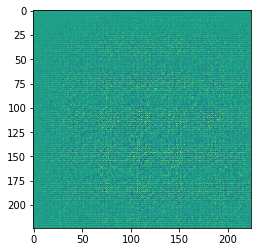

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.show()

### Creating the discriminator part of the model

In [ ]:
def discriminator_model():

  model = keras.Sequential([
      keras.layers.Conv2D(128, (5,5), (2,2), padding="same", use_bias=False, input_shape=(224, 224, 3)),
      keras.layers.LeakyReLU(),  
      keras.layers.Dropout(0.3),

      keras.layers.Conv2D(128, (5,5), (2,2), padding="same", use_bias=False),
      keras.layers.LeakyReLU(),
      keras.layers.Dropout(0.3),

      keras.layers.Conv2D(64, (5,5), (2,2), padding="same", use_bias=False),
      keras.layers.LeakyReLU(),
      keras.layers.Dropout(0.3),

      keras.layers.Conv2D(32, (5,5), (2,2), padding="same", use_bias=False),
      keras.layers.LeakyReLU(),
      keras.layers.Dropout(0.3),

      keras.layers.Flatten(),
      keras.layers.Dense(1, activation="sigmoid")
  ])

  return model

In [ ]:
discriminator = discriminator_model()

In [ ]:
res = discriminator(generated_image, training=False)

In [ ]:
res

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4999288]], dtype=float32)>

### custom loss functions